# Topic modelling: Latent Dirichlet Allocation

In the lectures, we learned two methods for topic modeling: Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA).

In this notebook, we demonstrate how to do topic modelling for a document corpus in PySpark using LDA. 

We show how to:
* tokenize and lemmatize textual data using the natural language tool kit (NLTK)
* convert words and documents into vector representations, specially, the use of sparse vectors
* the use of LDA to infer the latent topics of documents

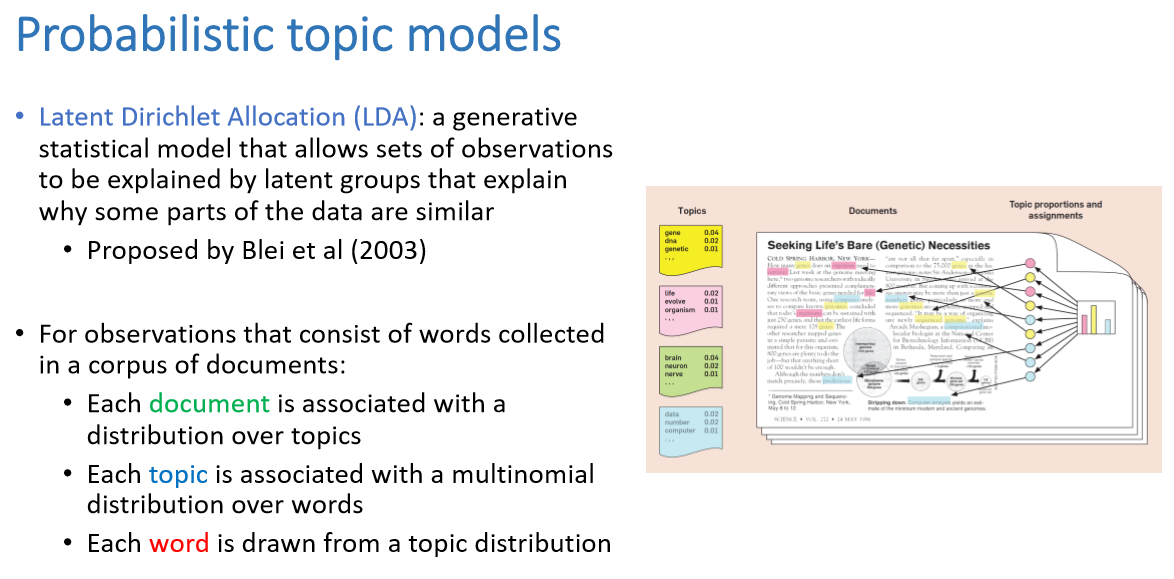

In [1]:
from IPython.display import Image
Image(filename='/home/m_e_barreto/LDA-0.png', width=900)

## Importing necessary libraries

In [1]:
import numpy as np
from time import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nl

[nltk_data]    |   Package maxent_treebank_pos_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package maxent_treebank_pos_tagger_tab to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package maxent_treebank_pos_tagger_tab is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package moses_sample to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package moses_sample is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package mte_teip5 to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package mte_teip5 is already up-to-date!
[nltk_data]    | Downloading package mwa_ppdb to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package mwa_ppdb is already up-to-date!
[nltk_data]    | 

[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package udhr is already up-to-date!
[nltk_data]    | Downloading package udhr2 to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package udhr2 is already up-to-date!
[nltk_data]    | Downloading package unicode_samples to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package unicode_samples is already up-to-date!
[nltk_data]    | Downloading package universal_tagset to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package universal_tagset is already up-to-date!
[nltk_data]    | Downloading package universal_treebanks_v20 to
[nltk_data]    |     /usr/local/share/nltk_data...
[nltk_data]    |   Package universal_treebanks_v20 is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloading package vader_lexicon to
[nltk_data]    

True

## Configuring Spark session

In [10]:
sc.defaultParallelism

2

## Load data

We are downloading the standard data set **20 newsgroup** (see https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)

In [2]:
from sklearn.datasets import fetch_20newsgroups

# download the dataset
dataset = fetch_20newsgroups(shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
# extracting data items
documents = dataset.data
# splitting data items into RDD partitions
news = sc.parallelize(documents)
# sample data items
news.take(2)

25/04/02 14:10:20 WARN TaskSetManager: Stage 0 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
 "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and haven't an

In [3]:
print('Number of partitions:', news.getNumPartitions())
n = news.count()
print('Number of messages/documents:', n)

Number of partitions: 2


25/04/02 14:10:25 WARN TaskSetManager: Stage 1 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


Number of messages/documents: 11314


## Data preprocessing

### 1. Parse the data

Here we make use of the Natural Language Processing module `nltk`. 

See https://www.nltk.org/install.html and https://www.nltk.org/data.html for more details.

We will have to process the messages to make them amenable to analysis. Important steps include:
* Tokenisation: chops text into useful units (words). 
* Lemmatisation: groups together inflected words, yields their dictionary form.

In [4]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer() # see https://www.nltk.org/_modules/nltk/stem/wordnet.html for details

def get_tokens(line):
    # get tokens from line
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [w for w in stripped if w.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

news_rdd = news.map(lambda line: (1, get_tokens(line)))
news_rdd.take(1)

25/04/02 14:10:32 WARN TaskSetManager: Stage 2 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


[(1,
  ['wondering',
   'anyone',
   'could',
   'enlighten',
   'car',
   'saw',
   'day',
   'sport',
   'car',
   'looked',
   'late',
   'early',
   'called',
   'bricklin',
   'door',
   'really',
   'small',
   'addition',
   'front',
   'bumper',
   'separate',
   'rest',
   'body',
   'know',
   'anyone',
   'tellme',
   'model',
   'name',
   'engine',
   'spec',
   'year',
   'production',
   'car',
   'made',
   'history',
   'whatever',
   'info',
   'funky',
   'looking',
   'car',
   'please',
   'email'])]

In [9]:
news_rdd.count()

25/04/02 14:29:19 WARN TaskSetManager: Stage 12 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


11314

### 2. Removing stop words

Some of the stop words are content specific (see [here](https://en.wikipedia.org/wiki/Stop_word)) 

Here we assume that words that appear very frequently are stop words. We use `3000` as a threshold.

In [6]:
doc_stop_words = news_rdd.flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
doc_stop_words = doc_stop_words.filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()

# throw away stop words and words that are just single letters.
news_rdd = news_rdd.map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words and not len(w)==1])) 

news_rdd.take(1)[0][1][:10]

25/04/02 14:12:23 WARN TaskSetManager: Stage 5 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
Exception in thread "serve RDD 8" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
25/04/02 14:14:45 WARN TaskSetManager: Stage 7 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


['wondering',
 'anyone',
 'could',
 'enlighten',
 'car',
 'saw',
 'day',
 'sport',
 'car',
 'looked']

In [7]:
news_rdd.take(1)

25/04/02 14:17:54 WARN TaskSetManager: Stage 8 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


[(1,
  ['wondering',
   'anyone',
   'could',
   'enlighten',
   'car',
   'saw',
   'day',
   'sport',
   'car',
   'looked',
   'late',
   'early',
   'called',
   'bricklin',
   'door',
   'really',
   'small',
   'addition',
   'front',
   'bumper',
   'separate',
   'rest',
   'body',
   'anyone',
   'tellme',
   'model',
   'name',
   'engine',
   'spec',
   'year',
   'production',
   'car',
   'made',
   'history',
   'whatever',
   'info',
   'funky',
   'looking',
   'car',
   'please',
   'email'])]

### 3. Convert tokens into sparse vectors

In [8]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

news_df = spark.createDataFrame(news_rdd, ["dummy","words"])
news_df.cache()
news_df.take(1)

25/04/02 14:20:09 WARN TaskSetManager: Stage 9 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:20:19 WARN TaskSetManager: Stage 10 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:23:52 WARN TaskSetManager: Stage 11 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


[Row(dummy=1, words=['wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'sport', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'door', 'really', 'small', 'addition', 'front', 'bumper', 'separate', 'rest', 'body', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'email'])]

In [11]:
news_df.show(10)

25/04/02 14:33:52 WARN TaskSetManager: Stage 13 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+
|dummy|               words|
+-----+--------------------+
|    1|[wondering, anyon...|
|    1|[fair, number, br...|
|    1|[well, folk, mac,...|
|    1|[weitek, addressp...|
|    1|[article, worldst...|
|    1|[course, term, mu...|
|    1|[responded, reque...|
|    1|[show, much, scsi...|
|    1|[win, downloaded,...|
|    1|[board, year, wor...|
+-----+--------------------+
only showing top 10 rows



Now, we generate vectors that are essentially histograms of word counts associated with each message (see https://spark.apache.org/docs/latest/ml-features.html#countvectorizer)

In [12]:
cv = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cv_model = cv.fit(news_df)

news_df_w_features = cv_model.transform(news_df)
news_df_w_features.cache()
news_df_w_features.show(10)

25/04/02 14:34:40 WARN TaskSetManager: Stage 14 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:34:51 WARN TaskSetManager: Stage 18 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:34:56 WARN TaskSetManager: Stage 19 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[wondering, anyon...|(30836,[0,1,32,37...|
|    1|[fair, number, br...|(30836,[18,29,37,...|
|    1|[well, folk, mac,...|(30836,[0,3,4,7,9...|
|    1|[weitek, addressp...|(30836,[29,38,118...|
|    1|[article, worldst...|(30836,[2,3,11,13...|
|    1|[course, term, mu...|(30836,[16,31,40,...|
|    1|[responded, reque...|(30836,[0,6,61,62...|
|    1|[show, much, scsi...|(30836,[8,9,10,11...|
|    1|[win, downloaded,...|(30836,[55,57,146...|
|    1|[board, year, wor...|(30836,[1,4,5,6,1...|
+-----+--------------------+--------------------+
only showing top 10 rows



### 4. Checking the vocabulary

The `cv` model stores the vocabulary separately from the histograms of words for each document.

In [13]:
print ("Vocabulary from CountVectorizerModel is:")
print(cv_model.vocabulary[:100])
print("\n---\n")

W = len(cv_model.vocabulary)
print("Number of terms W:", W)

Vocabulary from CountVectorizerModel is:
['could', 'year', 'system', 'new', 'make', 'say', 'file', 'good', 'may', 'well', 'problem', 'right', 'even', 'thing', 'way', 'see', 'first', 'work', 'two', 'much', 'many', 'god', 'want', 'need', 'program', 'go', 'used', 'window', 'said', 'number', 'question', 'point', 'anyone', 'something', 'take', 'come', 'since', 'please', 'information', 'drive', 'using', 'key', 'back', 'really', 'state', 'mean', 'going', 'look', 'still', 'part', 'find', 'case', 'day', 'game', 'believe', 'ca', 'must', 'help', 'government', 'available', 'law', 'last', 'thanks', 'email', 'might', 'another', 'run', 'data', 'group', 'got', 'without', 'line', 'made', 'let', 'better', 'etc', 'sure', 'read', 'give', 'never', 'set', 'space', 'fact', 'lot', 'power', 'name', 'however', 'armenian', 'card', 'support', 'list', 'car', 'version', 'around', 'tell', 'team', 'second', 'probably', 'someone', 'world']

---

Number of terms W: 30836


## Latent Dirichlet Allocation

We now analyse the same dataset using Latent Dirichlet Allocation (https://spark.apache.org/docs/2.2.0/mllib-clustering.html#latent-dirichlet-allocation-lda) to find feature vectors characterizing topics of documents, and feature vectors characterizing the words of topics.

In [10]:
#from IPython.display import Image
#Image(filename='/home/m_e_barreto/LDA-1.png', width=800)

Note that we assume the number of topics $k$ **a priori** (hyperparameter). Here we fix $k=20$

### Batch variational inference

In [11]:
#from IPython.display import Image
#Image(filename='/home/m_e_barreto/LDA-2.png', width=800)

In [14]:
from pyspark.ml.clustering import LDA

# instantiate LDA model
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.LDA.html
lda = LDA(k=4, maxIter=2)
# training the model
lda_model = lda.fit(news_df_w_features)

25/04/02 14:40:10 WARN TaskSetManager: Stage 20 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:40:11 WARN TaskSetManager: Stage 21 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:40:11 WARN OnlineLDAOptimizer: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
25/04/02 14:40:14 WARN TaskSetManager: Stage 22 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:40:15 WARN TaskSetManager: Stage 23 contains a task of very large size (5989 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:40:22 WARN TaskSetManager: Stage 24 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:40:23 WARN TaskSetManager: Stage 25 contains a task of very large size (5989 KiB). The maximum recommended task size is 1000 KiB.


The **perplexity** below is a measurement of *how well a probability model predicts a sample*. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.
You can think of it as being something like $2^{-\frac{1}{N}\sum_i \log_2q(x_i)}$, where $q$ is the model for the probability and the sum goes over $N$ test samples.  It is mainly used when comparing different models.

**Warning**: the section below may take a long time (30+ minutes) to complete

In [15]:
# calculate logLikelihood
ll = lda_model.logLikelihood(news_df_w_features)
# calculate perplexity
lp = lda_model.logPerplexity(news_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on the perplexity: " + str(lp))

25/04/02 14:43:45 WARN TaskSetManager: Stage 26 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:44:17 WARN TaskSetManager: Stage 27 contains a task of very large size (5988 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:44:23 WARN TaskSetManager: Stage 28 contains a task of very large size (5988 KiB). The maximum recommended task size is 1000 KiB.


The lower bound on the log likelihood of the entire corpus: -9138447.851297518
The upper bound on the perplexity: 9.332098221491693


In [17]:
# describe topics
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:")

topics.show(truncate=False)

# shows the results
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cv_model.vocabulary)[i])

The topics described by their top-weighted terms:
+-----+----------------------+-----------------------------------------------------------------------------------------------------------------+
|topic|termIndices           |termWeights                                                                                                      |
+-----+----------------------+-----------------------------------------------------------------------------------------------------------------+
|0    |[1, 9, 0, 4, 5]       |[0.002324098211876413, 0.001835957090038762, 0.0017348364996747168, 0.0017274968722048559, 0.0017134600079359542]|
|1    |[539, 21, 0, 232, 129]|[0.0010473311452871843, 6.805708184190955E-4, 5.745499702175533E-4, 5.689080307636812E-4, 4.957393122204293E-4]  |
|2    |[24, 27, 2, 39, 17]   |[0.001842939108786047, 0.0017138134567670177, 0.0016976433024050188, 0.0016258074542052268, 0.001245084707194723]|
|3    |[8, 6, 10, 15, 23]    |[8.4729511613761E-4, 8.198775009501239E-4, 6.93806

### Online LDA v.s. batch LDA

By specify the arguments in `LDA` class, we can switch between batch LDA and online LDA:
* default: batch LDA using EM algorithm.
* `optimizer='online'`: online LDA using online variational inference.

Here we run experiments on both algorithms and compare the results.

In [ ]:
#from IPython.display import Image
#Image(filename='/home/m_e_barreto/LDA-3.png', width=800)

In [19]:
news_train, news_test = news_df_w_features.randomSplit([8.0, 2.0], 24)

**WARNING**: the section below may take a long time (30+ minutes) to complete

In [20]:
# perplexity against documents function
def perplexity_vs_doc(lda, train, test, stage):
    testPreplexity = np.zeros(stage)
    computationTime = np.zeros(stage)
    fracs = np.linspace(0.1, 1.0, stage)
    num_repeat = 3
    for j in range(num_repeat):
        for i in range(stage):
            corpus = train.sample(False, fracs[i], 10*j)
            # Batch variational inference
            t0 = time()
            lda_model = lda.fit(corpus)
            t1 = time()
            computationTime[i] += (t1 - t0)/num_repeat
            testPreplexity[i] += lda_model.logPerplexity(test)/num_repeat
    return testPreplexity, computationTime

# set the seeds to have the same inital clustering
# batch LDA
test_preplexity_em, computation_time_em = perplexity_vs_doc(LDA(k=4, maxIter=2, seed=123), 
                                                            news_train, news_test, 10)
# online LDA
# test_preplexity_online, computation_time_online = perplexity_vs_doc(LDA(k=4, maxIter=2, optimizer='online', seed=123), 
#                                                                     news_train, news_test, 10)

25/04/02 14:50:43 WARN TaskSetManager: Stage 31 contains a task of very large size (5988 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:50:44 WARN TaskSetManager: Stage 32 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:50:44 WARN TaskSetManager: Stage 33 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:50:45 WARN TaskSetManager: Stage 34 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:50:45 WARN TaskSetManager: Stage 35 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:50:45 WARN TaskSetManager: Stage 36 contains a task of very large size (5989 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:50:46 WARN TaskSetManager: Stage 37 contains a task of very large size (5988 KiB). The maximum recommended task size is 1000 KiB.
25/04/

25/04/02 14:51:54 WARN TaskSetManager: Stage 90 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:51:54 WARN TaskSetManager: Stage 91 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:51:55 WARN TaskSetManager: Stage 92 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:51:55 WARN TaskSetManager: Stage 93 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:51:56 WARN TaskSetManager: Stage 94 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:52:02 WARN TaskSetManager: Stage 95 contains a task of very large size (5988 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:52:03 WARN TaskSetManager: Stage 96 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/

25/04/02 14:53:01 WARN TaskSetManager: Stage 148 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:53:02 WARN TaskSetManager: Stage 149 contains a task of very large size (5988 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:53:03 WARN TaskSetManager: Stage 150 contains a task of very large size (5988 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:53:09 WARN TaskSetManager: Stage 151 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:53:10 WARN TaskSetManager: Stage 152 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:53:10 WARN TaskSetManager: Stage 153 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:53:10 WARN TaskSetManager: Stage 154 contains a task of very large size (5989 KiB). The maximum recommended task size is 1000 KiB.

25/04/02 14:54:11 WARN TaskSetManager: Stage 206 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:54:20 WARN TaskSetManager: Stage 207 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:54:21 WARN TaskSetManager: Stage 208 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:54:21 WARN TaskSetManager: Stage 209 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:54:21 WARN TaskSetManager: Stage 210 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:54:21 WARN TaskSetManager: Stage 211 contains a task of very large size (7546 KiB). The maximum recommended task size is 1000 KiB.
25/04/02 14:54:22 WARN TaskSetManager: Stage 212 contains a task of very large size (5989 KiB). The maximum recommended task size is 1000 KiB.

### Testing preplexity vs training data size

NameError: name 'test_preplexity_online' is not defined

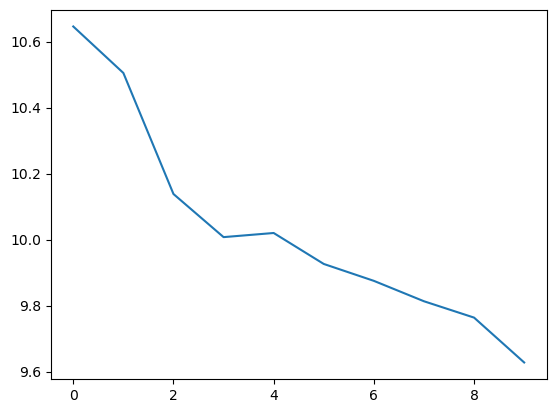

In [21]:
plt.plot(test_preplexity_em, label = "em")
plt.plot(test_preplexity_online, label = "online")
plt.xticks(np.arange(0, 10, 1), [str(i+1) for i in np.arange(0, 10, 1)])
plt.xlabel("Training data size *10%")
plt.ylabel("Testing preplexity")
plt.legend()
plt.show();

#### computation time vs training data size

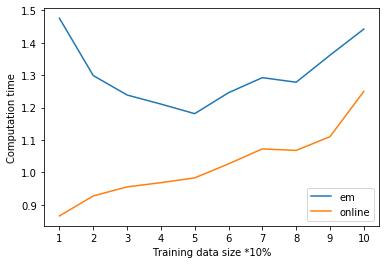

In [ ]:
plt.plot(computation_time_em, label = "em")
plt.plot(computation_time_online, label = "online")
plt.xticks(np.arange(0, 10, 1), [str(i+1) for i in np.arange(0, 10, 1)])
plt.xlabel("Training data size *10%")
plt.ylabel("Computation time")
plt.legend()
plt.show();

In [1]:
!pip install shap

In [2]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler

# 示例数据集
data = spark.createDataFrame([
    (1, 10, 0),
    (2, 20, 1),
    (3, 30, 0),
    (4, 40, 1),
    (5, 50, 0)
], ["feature1", "feature2", "label"])

# 特征向量化
assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
data = assembler.transform(data).select(col("features"), col("label"))


In [3]:
from pyspark.ml.classification import RandomForestClassifier

# 训练随机森林分类器
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)
model = rf.fit(data)


25/04/02 15:16:59 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 5 (= number of training instances)


In [4]:
import pandas as pd

# 提取训练数据（转换为 Pandas 格式）
data_pd = data.toPandas()
X = pd.DataFrame(data_pd["features"].tolist(), columns=["feature1", "feature2"])
y = data_pd["label"]


<Figure size 640x480 with 0 Axes>

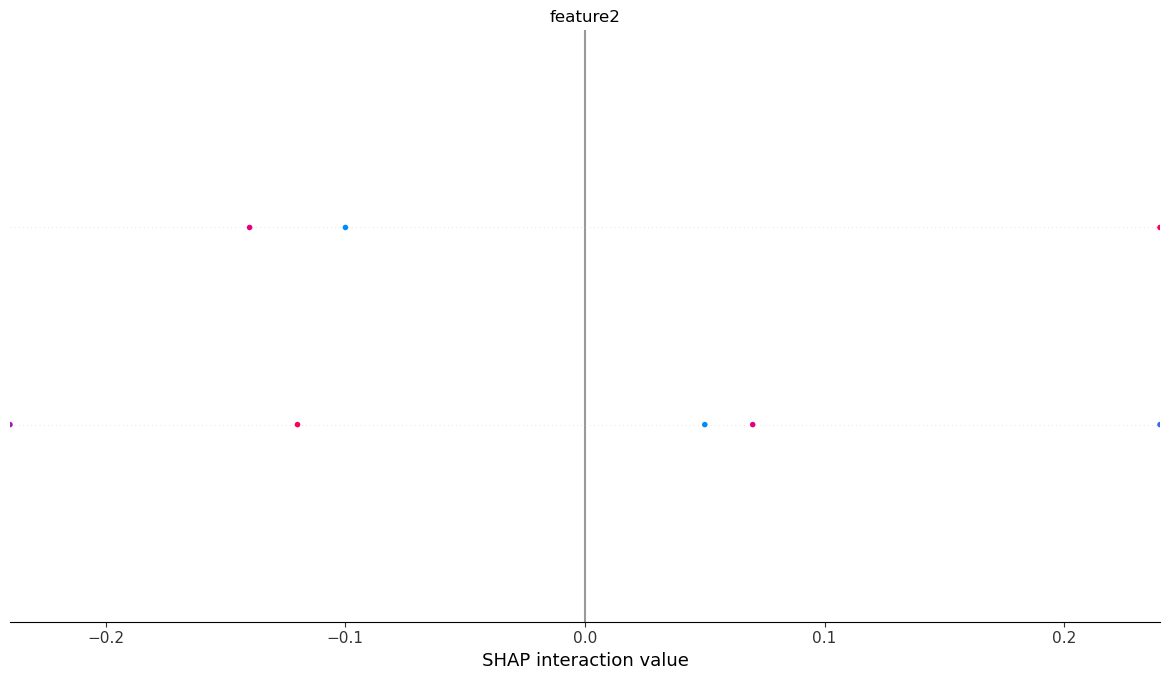

In [5]:
import shap
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# 训练一个 Scikit-learn 的随机森林模型（与 PySpark 版本一致）
sk_model = RandomForestClassifier(n_estimators=10)
sk_model.fit(X, y)

# 计算 SHAP 值
explainer = shap.Explainer(sk_model, X)
shap_values = explainer(X)

# 可视化 SHAP 重要性
shap.summary_plot(shap_values, X)
